Testing out the packages I wrote the other day. Let's see if I can implement kinetic models easily

In [2]:
import numpy as np
from matplotlib import pyplot as plt
from base_model import Model
from rejection_free_monte_carlo import RFMC

In [3]:
class Plaquette2D(Model):
    def __init__(self, x, y, T):
        self.T = T
        self.n_x = int(x)
        self.n_y = int(y)
        self._glass = np.random.randint(2, size = (self.n_x, self.n_y))*2 - 1
        self._generate_energy_change_array()
        self.total_energy()
        self.total_probability()
    
    def get_probabilities(self):
        return np.ravel(self._probabilities)
    
    def convert_index(self, index):
        return [int(index/self.n_x), int(index%self.n_x)]
    
    def total_energy(self):
        e = 0
        for i in range(self.n_x):
            for j in range(self.n_y):
                e += self._glass[i,j]\
                          *self._glass[(i+1)%self.n_x,j]\
                          *self._glass[i,(j+1)%self.n_y]\
                          *self._glass[(i+1)%self.n_x,(j+1)%self.n_y]
        self._energy = int(-e)
        return None
    
    def _generate_energy_change_array(self):
        self.energy_change_array = np.zeros((self.n_x,self.n_y))
        for i in range(self.n_x):
            for j in range(self.n_y):
                self.energy_change_array[i,j] = self._energy_change(i,j)
    
    def energy_update(self, step):
        x = step[0]
        y = step[1]

        self._energy += self.energy_change_array[x,y]

        # recompute energies around x and y
        a = np.array([-1, 0, 1], dtype = "int")
        for i in x + a:
            for j in y + a:
                self.energy_change_array[i%self.n_x, j%self.n_y] = self._energy_change(i%self.n_x, j%self.n_y)
        return
    
    def _energy_change(self, i, j):
        latt = self._glass
        t1 = latt[(i+1)%self.n_x,j]\
                    *latt[i,(j+1)%self.n_y]\
                    *latt[(i+1)%self.n_x,(j+1)%self.n_y]
        t2 = latt[(i+1)%self.n_x,j]\
                    *latt[i,(j-1)%self.n_y]\
                    *latt[(i+1)%self.n_x,(j-1)%self.n_y]
        t3 = latt[(i-1)%self.n_x,j]\
                    *latt[i,(j-1)%self.n_y]\
                    *latt[(i-1)%self.n_x,(j-1)%self.n_y]
        t4 = latt[(i-1)%self.n_x,j]\
                    *latt[i,(j+1)%self.n_y]\
                    *latt[(i-1)%self.n_x,(j+1)%self.n_y]
        
        return int(2*latt[i,j]*(t1+t2+t3+t4))
    
    def total_probability(self):
        self._probabilities = np.exp(-self.energy_change_array/self.T)
        self._probabilities[self._probabilities > 1] = 1
        return None
    
    def probability_update(self, step):
        # recompute probabilities around x and y
        x = step[0]
        y = step[1]
        a = np.array([-1, 0, 1], dtype = "int")
        for i in x + a:
            for j in y + a:
                self._probabilities[i%self.n_x, j%self.n_y] = np.min([1,np.exp(-self.energy_change_array[i%self.n_x, j%self.n_y]/self.T)])
        return
    
    def glass_update(self, step):
        x = step[0]
        y = step[1]
        self._glass[x,y] = -self._glass[x,y]
        return
    
    def rate(self):
        return np.sum(self._probabilities)

In [9]:
##model = Plaquette2D(4,4,0.1)
#x = RFMC(model,10)
#x.run()

In [9]:
import time

t0 = time.perf_counter()
temperatures = np.linspace(0.1,5,20)
energies = np.zeros(np.shape(temperatures))
i = 0
for T in temperatures:
    model = Plaquette2D(4,4,T)
    print('Temperature = %1.2f'%T)
    x = RFMC(model)
    x.run(1600)
    energies[i] = x.get_mean()/16
    i += 1
    print(time.perf_counter()-t0)
    t0 = time.perf_counter()

Temperature = 0.10
0.558665899999994
Temperature = 0.36
0.5422615999999607
Temperature = 0.62
0.5821700999999848
Temperature = 0.87
0.5425970000000007
Temperature = 1.13
0.5639944000000128
Temperature = 1.39
0.5381945999999971
Temperature = 1.65
0.5222385999999801
Temperature = 1.91
0.5310706999999866
Temperature = 2.16
0.5428417999999624
Temperature = 2.42
0.553058300000032
Temperature = 2.68
0.5604438999999957
Temperature = 2.94
0.5416601000000014
Temperature = 3.19
0.5425640000000271
Temperature = 3.45
0.5227849000000333
Temperature = 3.71
0.5657176999999933
Temperature = 3.97
0.5250594000000319
Temperature = 4.23
0.5324843999999871
Temperature = 4.48
0.5293653000000518
Temperature = 4.74
0.5442429000000288
Temperature = 5.00
0.5379833999999732


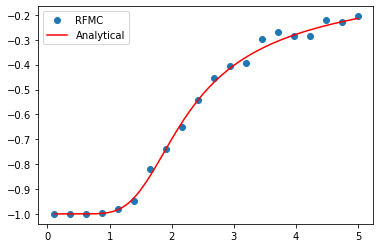

In [10]:
plt.plot(temperatures, energies,'o',label='RFMC')
import pandas as pd
data = pd.read_csv('4x4_Plaquette_Analytical_Solution.csv',sep='\t',header=None)
plt.plot(data[0],data[1],'r',label='Analytical')
z=plt.legend()

In [7]:
import time

t0 = time.perf_counter()
temperatures1000 = np.linspace(0.1,5,10)
energies1000 = np.zeros(np.shape(temperatures1000))
i = 0
for T in temperatures1000:
    model = Plaquette2D(2**8,2**8,T)
    print('Temperature = %1.2f'%T)
    x = RFMC(model)
    x.run(2**20)
    energies1000[i] = x.get_mean()/2**16
    i += 1
    print(time.perf_counter()-t0)
    t0 = time.perf_counter()
    

Temperature = 0.10
1230.8542798999997
Temperature = 0.64
1078.0389864999997
Temperature = 1.19
2363.2035429999996
Temperature = 1.73
3044.1661421999997
Temperature = 2.28


KeyboardInterrupt: 

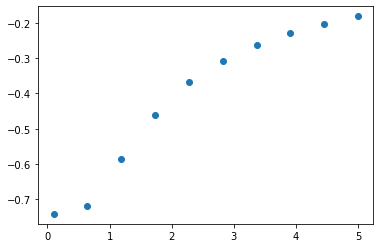

In [6]:
plt.plot(temperatures1000, energies1000,'o',label='RFMC')

In [6]:
# Assessing large scale performance
import cProfile

def perform():
    model = Plaquette2D(2**8,2**8,5)
    x = RFMC(model)
    x.run(1e6)
    
cProfile.run("perform()")

         19558770 function calls in 153.639 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
  1235484    0.831    0.000   13.503    0.000 <__array_function__ internals>:2(amin)
        1    0.000    0.000    0.000    0.000 <__array_function__ internals>:2(prod)
   137277    0.122    0.000    0.802    0.000 <__array_function__ internals>:2(ravel)
   137276    0.118    0.000    0.312    0.000 <__array_function__ internals>:2(size)
   274553    0.207    0.000   12.067    0.000 <__array_function__ internals>:2(sum)
   137277    0.126    0.000    0.928    0.000 <ipython-input-3-5200ec3a2d19>:11(get_probabilities)
   137276    0.267    0.000    0.267    0.000 <ipython-input-3-5200ec3a2d19>:14(convert_index)
        1    0.097    0.097    0.097    0.097 <ipython-input-3-5200ec3a2d19>:17(total_energy)
        1    0.000    0.000    0.525    0.525 <ipython-input-3-5200ec3a2d19>:2(__init__)
        1    0.044    0.044    0.426    0.4

KeyboardInterrupt: 

In [3]:
# Assessing large scale performance
import cProfile

def perform():
    model = Plaquette2D(2**10,2**10,5)
    x = RFMC(model)
    x.run(1e4)
    
cProfile.run("perform()")

         2468637 function calls in 184.945 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
    90000    0.072    0.000    1.020    0.000 <__array_function__ internals>:2(amin)
        1    0.000    0.000    0.000    0.000 <__array_function__ internals>:2(prod)
    10000    0.012    0.000    0.086    0.000 <__array_function__ internals>:2(ravel)
    10000    0.009    0.000    0.026    0.000 <__array_function__ internals>:2(size)
    20000    0.020    0.000   24.996    0.001 <__array_function__ internals>:2(sum)
    10000    0.015    0.000    0.100    0.000 <ipython-input-2-5200ec3a2d19>:11(get_probabilities)
    10000    0.041    0.000    0.041    0.000 <ipython-input-2-5200ec3a2d19>:14(convert_index)
        1    1.720    1.720    1.720    1.720 <ipython-input-2-5200ec3a2d19>:17(total_energy)
        1    0.004    0.004    7.933    7.933 <ipython-input-2-5200ec3a2d19>:2(__init__)
        1    0.602    0.602    6.181    6.18